# Introduction to FBL: Part 6: Executing Circuits

In this demo, we show how one can perform circuit execution.
We have an example script for the execution of a cartridge:
* load_retina_lamina

We can use it as follows:

In [2]:
%matplotlib inline

In [3]:
client = nm[0]
res = client.load_retina_lamina(cartridgeIndex=1)
cart = res['success']['result']['data']
ret = cart['LPU']['retina']
lam = cart['LPU']['lamina']

[FFBOLab Client NLP 2020-07-14 12:47:36] Received a message.
[FFBOLab Client NLP 2020-07-14 12:47:36] Received a message.
[FFBOLab Client NLP 2020-07-14 12:47:36] Received a message.
Pruning  []
Pruning  []
[FFBOLab Client NLP 2020-07-14 12:47:41] Received a message.
Retina and lamina circuits have been successfully loaded.


Configure inputs and what to record.

In [4]:

dt = 1e-4
dur = 0.1
steps = int(dur/dt)

retina_input_config = {
    'General': {'dt': dt},
    'Retina': {'screentype': 'Sphere',
               'filtermethod': 'gpu',
               'radius': 1.0,
               'intype': 'Gratings',
               'screen_write_step': 1000,
               },
    'InputType': {'shape': [128, 128],
                  'infilename': 'image_inputs.h5',
                  'writefile': False,
                  'Gratings': {
                            'x_freq': 0.02,
                            'y_freq': 0.0,
                            'x_speed': 400.0,
                            'y_speed': 0.0,
                            'sinusoidal': False,
                            'levels': [3e1, 3e4]}
                 },
    'Screen': {'SphereScreen': {'parallels': 50,
                                'meridians': 800,
                                'radius': 10.,
                                'half': True,
                                'image_map': 'AlbersProjectionMap'}
              }
}
photoreceptor_list = [(node, v) for node, v in ret['nodes'].items() if v['class'] == 'PhotoreceptorModel']

input_processors = {'retina': [{'class': 'RetinaInputIndividual',
                            'module': 'retina.InputProcessors.RetinaInputIndividual', # this is where PB_InputProcessor should be imported from
                            'config': retina_input_config,
                            'photoreceptor_list': photoreceptor_list,
                            'input_file': 'retina_inputs.h5',
                            'input_interval': 10}]
                   }

output_processors = {'retina': [{'class': 'Record',
                             'uid_dict': {'V': {'uids': [rid for rid, v in ret['nodes'].items() if v['label'].startswith('neuron') and v['class'] not in ['Port', 'BufferVoltage']]},
                                          },
                             'sample_interval': 10}
                           ],
                     'lamina': [{'class': 'Record',
                             'uid_dict': {'V': {'uids': [rid for rid, v in lam['nodes'].items() if v['label'].startswith('neuron') and v['class'] not in ['Port', 'BufferVoltage']]},
                                          },
                             'sample_interval': 10}
                           ]
                    }


Execute the LPUs, the simulation name is 'cartridge1'.

In [5]:
client.execute_multilpu('cartridge1',
                        inputProcessors = input_processors,
                        outputProcessors = output_processors,
                        dt = dt, steps = steps)

{'nlp': {7880903303412753: {'name': 'nlp_server'}}, 'na': {3199360975743091: {'name': 'na_server_with_vfb_links'}}, 'nk': {2094084208404649: {'name': 'nk_server'}}}
[FFBOLab Client NLP 2020-07-14 12:47:45] Received a message.
Execution request sent. Please wait.
[FFBOLab Client NLP 2020-07-14 12:48:09] Receiving Execution Result for cartridge1.  Please wait .....
[FFBOLab Client NLP 2020-07-14 12:48:09] Received Execution Result for cartridge1. Result stored in Client.exec_result['cartridge1']


Update the simulation result with proper label. Note that simulation results are returned with keys reflecting the rids of nodes in the database. Here, we relabel each component with their name.

In [6]:
label_dict = {rid: v['label'] for lpu_name, lpu in cart['LPU'].items() for rid, v in lpu['nodes'].items()}
client.updateSimResultLabel('cartridge1', label_dict)

Finally, we plot the result for simulation result 'cartridge1'.

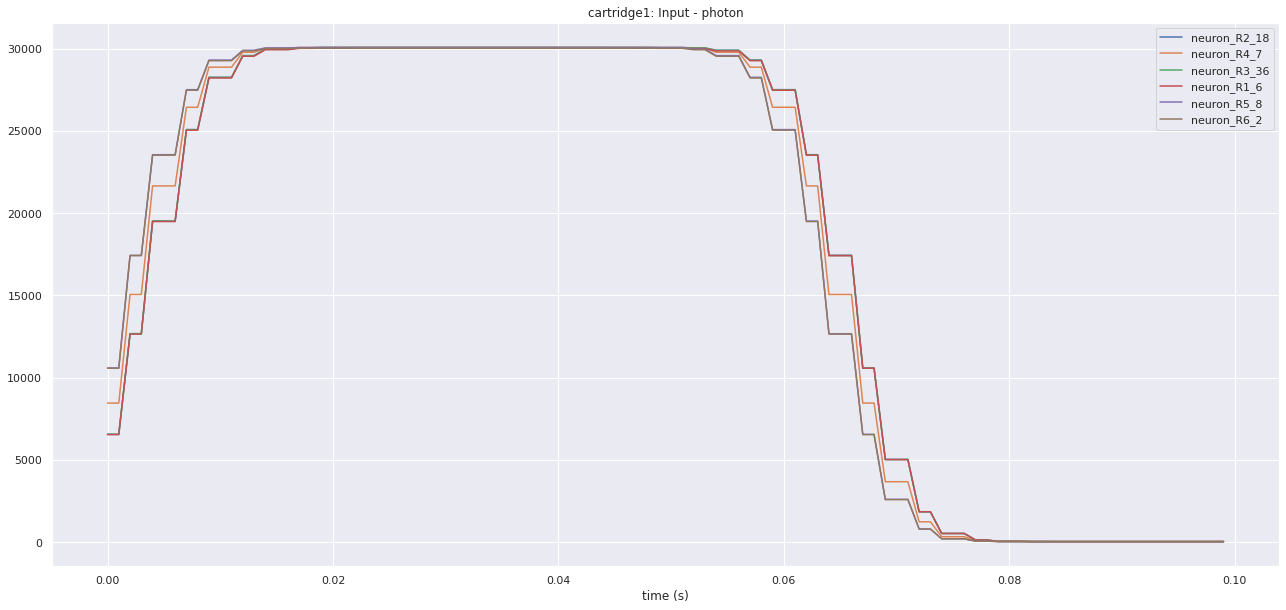

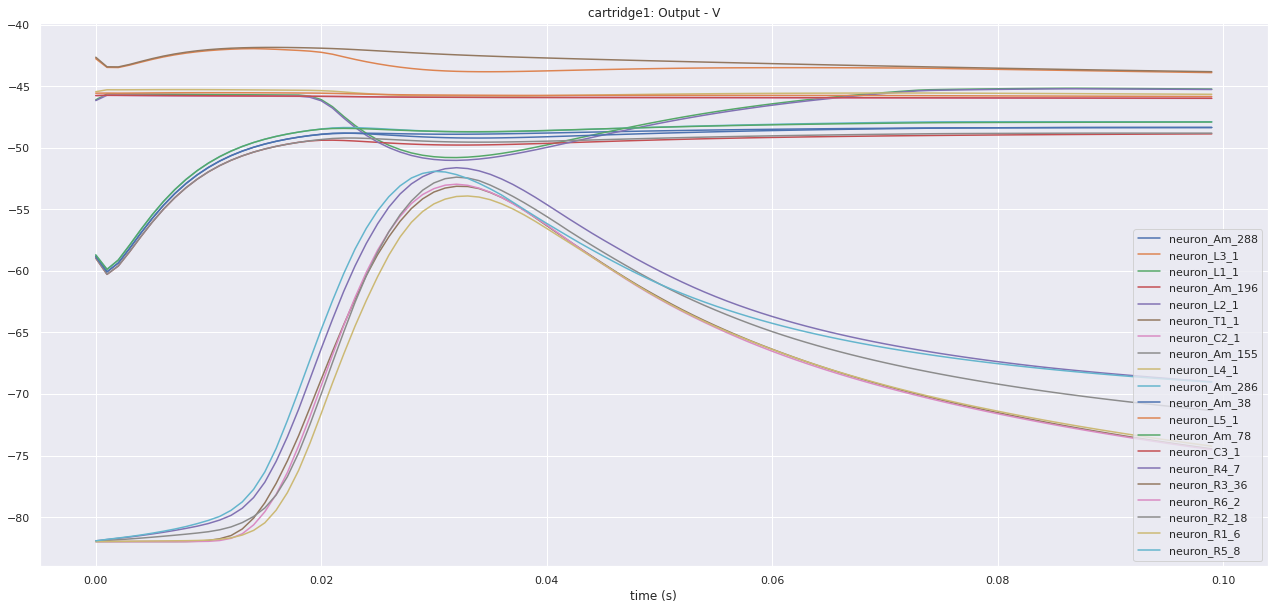

In [7]:
client.plotExecResult('cartridge1')

Note that these scripts only provide a bare-bones implementation.